## 6 class AD PD model

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,auc
import colorama
from colorama import Fore, Style
matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

In [2]:
def getdata():
    
    
    data = pd.read_csv("fourcl.csv").to_numpy()
    labels = pd.read_csv("fourcl_labels.csv").to_numpy().squeeze()
    # changing labels to Class A and B    
    labelscenter = labels
    labelscenter = np.where(labels == 'A1','A',labelscenter) 
    labelscenter = np.where(labels == 'A2','A',labelscenter) 
    labelscenter = np.where(labels == 'B1','B',labelscenter) 
    labelscenter = np.where(labels == 'B2','B',labelscenter) 

    
    # changing labels to Class A and B    
    labelsdiseases = labels
    labelsdiseases = np.where(labels == 'A1','1',labelsdiseases) 
    labelsdiseases = np.where(labels == 'A2','2',labelsdiseases) 
    labelsdiseases = np.where(labels == 'B1','1',labelsdiseases) 
    labelsdiseases = np.where(labels == 'B2','2',labelsdiseases) 

    
    dataforplot = data
    scalar = StandardScaler()
    dataforplot = scalar.fit_transform(dataforplot)
    return data,labelscenter,labelsdiseases,scalar,dataforplot

In [3]:
def ztransform(data_ztransform,scalarz):
    # Sklearn's standardscaler to perform z-transform

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    #scalar = scalar
    data_ztransform = scalarz.fit_transform(data_ztransform)
    
    return data_ztransform,scalarz

In [4]:
class ProcessLogger:
    def __init__(self):
        self.states = np.array([])

    # A callback function has to accept two arguments, i.e., model and state, where model is the
    # current model, and state contains a number of the optimizers variables.
    def __call__(self, state):
        self.states = np.append(self.states, state)
        return False  # The callback function can also be used to stop training early,
        # if some condition is met by returning True.

        
        
logger = ProcessLogger()



In [5]:
def model_definition_center():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
        #wgd
    solver_type="wgd",
    solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
    #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [6]:
def model_definition_disease(correctionmatrix):
    model1 = GMLVQ(
        distance_type="adaptive-squared-euclidean",
        activation_type="sigmoid",
        activation_params={"beta": 2},
        solver_type="wgd",
        solver_params={"max_runs": 50,"step_size": np.array([0.1, 0.05]),"callback": logger},
        #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
        random_state=1428,
        relevance_correction=correctionmatrix
    )
    return model1

In [7]:
#run the whole notebook for max runs say(1-10000) # check exactly what does max runs define in this. calculate the loss and store at each max runs step

In [8]:
def train_modelkfold(data, label,disease,correctionmatrix1,repeated,scalar,folds=10):
    modelmatrix = np.zeros((repeated,folds),dtype=object) 
    scalars = np.zeros((repeated,folds),dtype=object)
    datamatrix =  np.zeros((repeated,folds),dtype=object) 
    labelmatrix = np.zeros((repeated,folds),dtype=object)
    accuracies = np.zeros((repeated,folds),dtype=float) 
    # each entry will store the test labels and the predicted labels
    testlabels = np.zeros((repeated,folds),dtype=object) 
    predicted = np.zeros((repeated,folds),dtype=object) 
    probablities = np.zeros((repeated,folds),dtype=object) 
    laeblscore = np.zeros((repeated,folds),dtype=object) 
    testing_indicesM = np.zeros((repeated,folds),dtype=object) 
    traning_indicesM = np.zeros((repeated,folds),dtype=object) 
    
    if disease==False:
        print('Repeated K fold for center data')
    else:
        print('Repeated K fold for disease data')
    for repeated in range(repeated):
        
        print("========Repeated fold number",str(repeated),"========")
        kfold = KFold(folds, shuffle=True)
        
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data)):
            if disease==False:
                model = model_definition_center()
                #print('in this')
                #print(type(model))
            else:
                #model = model_definition_center()
                model = model_definition_disease(correctionmatrix1)
            accuracy = 0
            correct = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            #applying z transform on training data only
            trainX,scalar1 = ztransform(trainX,scalar)
            model.fit(trainX,trainY)
            
            # model is fitted, can also do = model
            modelmatrix[repeated,k] = model
            datamatrix[repeated,k] = trainX
            
            
            labelmatrix[repeated,k] = trainY

            testX = scalar1.transform(testX)
            predictedlabels = model.predict(testX)
            #print(confusion_matrix(testX, predictedlabels))
            for i in range(len(predictedlabels)):
                if(predictedlabels[i]==testY[i]):
                    correct = correct+1
                    
            scalars[repeated,k] = scalar1
            
            probabilties = model.predict_proba(testX)
            
            laeblscore[repeated,k] = model.decision_function(testX)
            
            probablities[repeated,k] = probabilties
            
            testlabels[repeated,k] = testY
            
            predicted[repeated,k] = predictedlabels
            
            
            testing_indicesM[repeated,k] = testing_indices
            traning_indicesM[repeated,k] = training_indices
            
            accuracy = correct/len(testY)
            print('%.3f accuracy' % (correct/len(testY)))
    return modelmatrix,datamatrix,labelmatrix,scalars,testlabels,predicted,probablities,laeblscore,testing_indicesM,traning_indicesM

In [9]:
def calculate_lambda(modelmatrix,repeated):
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    #check the shape of total_lambda
    
    total_lambda = np.zeros((10,10),dtype = 'float')
    print(repeated)
    for index in range(repeated):
        print(index)
        lambdaperfold = np.zeros((10,10),dtype='float')        
        
        for modelin in modelmatrix[index,:]:
            lambdaperfold = lambdaperfold + modelin.lambda_

        lambdaperfold = lambdaperfold/np.shape(modelmatrix)[1]
        
        total_lambda = total_lambda + lambdaperfold
        
    total_lambda = total_lambda/repeated

    return total_lambda

In [10]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # eigen vectors returned in columns
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    
    # eigenvectors are row matrices
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [11]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']#, 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [12]:

def correction_matrix(eigvectorscenter):
    N=10
    K=1
    I = np.identity(N)
    outerproduct = np.zeros((N,N))   
    for i in range(K):
        # check this
        outerproduct +=  np.outer(eigvectorscenter.T[:,i],eigvectorscenter[i,:])
        outerproduct1 =  np.outer(eigvectorscenter.T[:,0],eigvectorscenter[0,:])
        outerproduct2 =  np.outer(eigvectorscenter.T[:,1],eigvectorscenter[1,:])        
    correctionmatrix = I-outerproduct
    return correctionmatrix

In [13]:
def calculate_prototype(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[i].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

In [14]:
def calculate_prototype1(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

## get data

In [ ]:
repeated = 100
folds = 10

## center data fitting (3 class)

In [15]:
data,labelscenter,labelsdiseases,scalar,dataforplot = getdata()

centermodel,datamatrix,labelmatrix,scalars1,testlabelsc,predictedc,probabiltiesc,laeblscorec,testing_indicesC,training_indicesC = train_modelkfold(data,labelscenter,False,None,repeated,scalar,folds)

average_lambda_center = calculate_lambda(centermodel,repeated)

average_prototype_center = calculate_prototype(centermodel,repeated,10,scalars1)

print('                                                     ')


print('The sum of the digonal of the center relevance matrix')

print(np.sum(np.diagonal(average_lambda_center)))

print('                                                     ')


eigenvaluescenter,eigenvectorscenter = eigendecomposition(average_lambda_center)


correctionmatrix1 = correction_matrix(eigenvectorscenter)

#correctionmatrix = correction_matrix()


Repeated K fold for center data
========Repeated fold number 0 ========
0.787 accuracy
0.785 accuracy
0.770 accuracy
0.782 accuracy
0.765 accuracy
0.782 accuracy
0.750 accuracy
0.755 accuracy
0.792 accuracy
0.787 accuracy
========Repeated fold number 1 ========
0.785 accuracy
0.770 accuracy
0.777 accuracy
0.782 accuracy
0.757 accuracy
0.767 accuracy
0.818 accuracy
0.765 accuracy
0.757 accuracy
0.749 accuracy
========Repeated fold number 2 ========
0.762 accuracy
0.767 accuracy
0.780 accuracy
0.748 accuracy
0.777 accuracy
0.792 accuracy
0.833 accuracy
0.772 accuracy
0.740 accuracy
0.777 accuracy
========Repeated fold number 3 ========
0.775 accuracy
0.807 accuracy
0.750 accuracy
0.762 accuracy
0.757 accuracy
0.802 accuracy
0.795 accuracy
0.755 accuracy
0.787 accuracy
0.767 accuracy
========Repeated fold number 4 ========
0.765 accuracy
0.787 accuracy
0.755 accuracy
0.767 accuracy
0.802 accuracy
0.810 accuracy
0.775 accuracy
0.770 accuracy
0.777 accuracy
0.754 accuracy
========Repeated f

## Disease data fitting 4 class AD PD

In [16]:

diseasemodel,datamatrix1,labelmatrix1,scalars2,testlabelsd,predictedd,probabiltiesd,laeblscored,testing_indicesD,training_indicesD  = train_modelkfold(data,labelsdiseases,True,None,repeated,scalar)

average_lambda_disease = calculate_lambda(diseasemodel,repeated)

eigenvaluesdisease,eigenvectorsdisease = eigendecomposition(average_lambda_disease)


average_prototype_disease = calculate_prototype1(diseasemodel,repeated,10,scalars2)




print('The sum of the digonal of the disease relevance matrix')

print(np.sum(np.diagonal(average_lambda_disease)))


Repeated K fold for disease data
========Repeated fold number 0 ========
0.970 accuracy
0.945 accuracy
0.950 accuracy
0.965 accuracy
0.960 accuracy
0.970 accuracy
0.958 accuracy
0.970 accuracy
0.973 accuracy
0.955 accuracy
========Repeated fold number 1 ========
0.975 accuracy
0.965 accuracy
0.970 accuracy
0.968 accuracy
0.965 accuracy
0.953 accuracy
0.938 accuracy
0.970 accuracy
0.945 accuracy
0.960 accuracy
========Repeated fold number 2 ========
0.953 accuracy
0.963 accuracy
0.975 accuracy
0.955 accuracy
0.960 accuracy
0.965 accuracy
0.980 accuracy
0.945 accuracy
0.960 accuracy
0.957 accuracy
========Repeated fold number 3 ========
0.965 accuracy
0.970 accuracy
0.965 accuracy
0.950 accuracy
0.958 accuracy
0.968 accuracy
0.970 accuracy
0.968 accuracy
0.948 accuracy
0.945 accuracy
========Repeated fold number 4 ========
0.953 accuracy
0.955 accuracy
0.960 accuracy
0.970 accuracy
0.973 accuracy
0.948 accuracy
0.965 accuracy
0.963 accuracy
0.958 accuracy
0.972 accuracy
========Repeated 

## single model trained on 4 class disease and 3 class center data

In [17]:
# training an individual model
    
modelc = model_definition_center()

centerdata,scalarIc = ztransform(data,scalar)

modelc.fit(data,labelscenter)

correctionmatrix12 = correction_matrix(modelc.eigenvectors_)

data,scalarId = ztransform(data,scalar)

# single disease model corrected on single center correction matrix
modeld = model_definition_disease(None)

modeld1 = model_definition_disease(None)

modeld.fit(data,labelsdiseases)

predictedlabels = modeld.predict(data)

## Zero dot product

In [18]:
# removed the influence of the leading eigen vector from each 
first_eigen_vector = np.dot(diseasemodel[0][3].eigenvectors_[0,:],eigenvectorscenter[1,:])
print(first_eigen_vector)

-0.8516462360334474


In [19]:
def check_orthogonality(centermodel,diseasemodel,dimensions,repeated,folds,eigenvectorscenter):
    centerlist = list(chain.from_iterable(zip(*centermodel)))
    disease_center = list()
    disease_averagecenter= list()
    for j in range(2):
        for array,modeld in enumerate(diseasemodel[j]):
            disease_averagecenter.append(np.dot(modeld.eigenvectors_[:2,:],eigenvectorscenter[:2,:].T))
            for modelc in centerlist:
                # eigenvectors are row vectors
                disease_center.append((np.dot(modeld.eigenvectors_[:2,:],modelc.eigenvectors_[:2,:].T)))
    return disease_averagecenter,disease_center

In [20]:
def transform1(X,eigenvaluesaverage,eigenvectoraverage,scale):
    eigenvaluesaverage[eigenvaluesaverage < 0] = 0
    eigenvectoraverage1 = np.sqrt(eigenvaluesaverage[:, None]) * eigenvectoraverage
    if scale == True:
        return np.matmul(X, eigenvectoraverage1.T)
    return np.matmul(X, eigenvectoraverage.T)

In [21]:
modeld.classes_

array(['1', '2'], dtype=object)

## confusion matrix 

In [22]:
def confusionmatrix(test,predicted):
    oneone=onetwo=twoone=twotwo=0
    oneone, onetwo, twoone, twotwo = confusion_matrix(test, predicted, labels=['1','2']).ravel()
            
    return oneone, onetwo, twoone, twotwo
            

In [23]:
def confusionmatrix_61class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    #testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    #predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    #1class only passing one set of test and predicted labels
    testlist = testlabelmatrix
    predictedlist = predictedlabelmatrix


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    one_tpr = dict()
    one_fpr = dict()
    
    
    two_tpr = dict()
    two_fpr = dict()
    
    none_fpr=none_tpr= ntwo_fpr= ntwo_tpr=0
    
    
    oneone, onetwo, twoone, twotwo = confusionmatrix(testlabelmatrix,predictedlabelmatrix)
        
    none_fpr = (twoone)/(twoone+twotwo)
    none_tpr = (oneone)/(oneone+onetwo)


    ntwo_fpr = (onetwo)/(onetwo+oneone)
    ntwo_tpr = (twotwo)/(twotwo+twoone)

    #############################
    one_fpr = none_fpr
    one_tpr = none_tpr
    
    
    two_fpr = ntwo_fpr
    two_tpr = ntwo_tpr
    # add to the dictionary
    #pd_fpr[i].append(npd_fpr)
    #pd_tpr[i].append(npd_tpr)
    #ad_fpr[i].append(nad_fpr)
    #ad_tpr[i].append(nad_tpr)

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return one_fpr,one_tpr,two_fpr,two_tpr

In [24]:
def confusionmatrix_6class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    
    

    
    one_tpr = dict()
    one_fpr = dict()
    
    
    two_tpr = dict()
    two_fpr = dict()
    # all are averge rates
    # later might store in a matrix to index exact model
    for i in range(len(testlist)):        
        none_fpr=none_tpr= ntwo_fpr= ntwo_tpr=0
        oneone, onetwo, twoone, twotwo = confusionmatrix(testlist[i],predictedlist[i])

        none_fpr = (twoone)/(twoone+twotwo)
        none_tpr = (oneone)/(oneone+onetwo)


        ntwo_fpr = (onetwo)/(onetwo+oneone)
        ntwo_tpr = (twotwo)/(twotwo+twoone)


        #############################
        one_fpr[i] = none_fpr
        one_tpr[i] = none_tpr

        two_fpr[i] = ntwo_fpr
        two_tpr[i] = ntwo_tpr
        
#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return one_fpr,one_tpr,two_fpr,two_tpr

In [25]:
testlabelsdsingle = np.concatenate(list(chain.from_iterable(zip(*testlabelsd))), axis=0 )
predicteddsingle = np.concatenate( list(chain.from_iterable(zip(*predictedd))), axis=0 )
probabiltysingle = np.concatenate( list(chain.from_iterable(zip(*probabiltiesd))), axis=0 )

## confusion matrix for kfold models

In [26]:
one_fpr,one_tpr,two_fpr,two_tpr = confusionmatrix_6class(diseasemodel,testlabelsd,predictedd)

one_fpr1,one_tpr1,two_fpr1,two_tpr1 = confusionmatrix_61class(diseasemodel,testlabelsdsingle,predicteddsingle)

## create dictionary for models and an averaged model

In [27]:
n_classes=['1','2']
plotdict_tpr1 = dict()
plotdict_fpr1 = dict()

plotdict_tpr1 = one_tpr1,two_tpr1
plotdict_fpr1 = one_fpr1,two_fpr1

In [28]:
n_classes=['1','2']
plotdict_tpr = dict()
plotdict_fpr = dict()

#for j in range(len(repeated)*folds):
for j in range(repeated*folds):

    
    plotdict_tpr[j] = one_tpr[j],two_tpr[j]
    plotdict_fpr[j]= one_fpr[j],two_fpr[j]

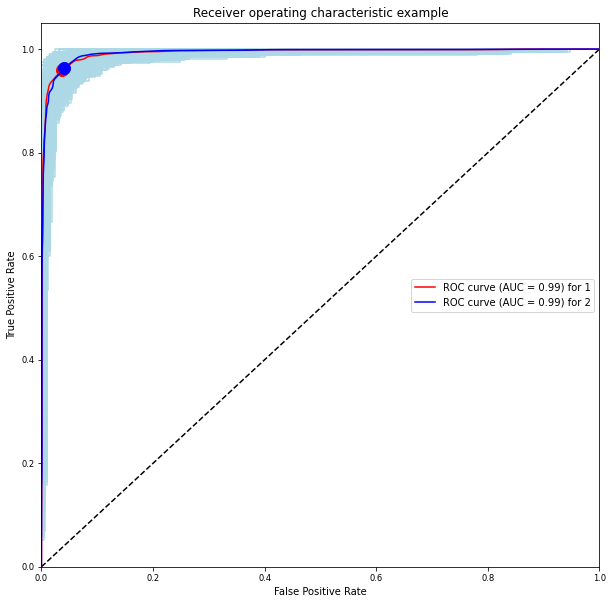

In [29]:
testlist = list(chain.from_iterable(zip(*testlabelsd)))
probabiltylist = list(chain.from_iterable(zip(*probabiltiesd)))
fpru = dict()
tpru = dict()
roc_aucu = dict()
for k in range(len(testlist)):

    n_classes=['1','2']
    # structures
    fpr = dict()

    tpr = dict()

    roc_auc = dict()
    
    
    
    fpr1 = dict()

    tpr1 = dict()

    roc_auc1 = dict()
    

    colorrange = ['lightblue','lightblue']
    colorrange2 = ['red','blue']
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(testlist[k],probabiltylist[k][:,i],pos_label=n_classes[i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
        fpru[k] = fpr
        tpru[k] = tpr
        roc_aucu[k] = roc_auc
        
    for j in range(len(n_classes)):
        fpr1[j], tpr1[j], _ = roc_curve(testlabelsdsingle,probabiltysingle[:,j],pos_label=n_classes[j], drop_intermediate=True)
        roc_auc1[j] = auc(fpr1[j], tpr1[j])
        

    
    
    
figsize=(10, 10)
# roc for each class
fig, ax = plt.subplots(figsize=figsize)



ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example') 


for k1 in range(len(testlist)):
    for i1 in range(len(n_classes)):  
        ax.plot(fpru[k1][i1], tpru[k1][i1], label='_nolegend_',color=colorrange[i1])

        #ax.plot(PDCUN_fpr[i], PDCUN_fpr[i],  marker="o", markersize="12")
        ax.plot(plotdict_fpr[k1][i1], plotdict_tpr[k1][i1],  color=colorrange[i1])#,marker="o", markersize="12")
        
        
#plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
#plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUMCG_fpr1

for i2 in range(len(n_classes)):
    ax.plot(fpr1[i2], tpr1[i2], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[i2], n_classes[i2]),color=colorrange2[i2])
    ax.plot(plotdict_fpr1[i2], plotdict_tpr1[i2], color=colorrange2[i2],marker="o", markersize="12")


ax.legend(loc="right")   
ax.grid(False)
fig.savefig('roc6class.png')
#ax.grid(alpha=.4)
plt.show()

In [30]:
# removing the z transform
def visualizeSinglemodel(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','brown']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

## ROC curve for one trained model for 6 class classification

In [31]:
# removing the z transform
def averageprototype(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]


    #transformed_model = model.transform(prototypes, scale=True)
    #prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(average_prototype,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.transform(prototypes, scale=True)
    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['pink','brown']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel_kfold2d.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [42]:
# removing the z transform
def visualizeSinglemodelc(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset center data with corresponding prototypes")
    colors = ['pink','brown']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [43]:
# removing the z transform
def averageprototypec(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,average_prototype):
    data = scalarI.inverse_transform(data)
    transformed_data = transform1(data,eigenvaluesdisease,eigenvectoraverage,True)

    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]


    #transformed_model = model.transform(prototypes, scale=True)
    #prototypes = scalarI.inverse_transform(average_prototype)
    transformed_model = transform1(average_prototype,eigenvaluesaverage,eigenvectoraverage,scale=True)
    #transformed_model = model.prototypes(prototypes, scale=True)
    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]
    fig, ax = plt.subplots()
    fig.suptitle("Maindataset center data with corresponding prototypes")
    colors = ['pink','brown']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel_kfold2d.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

returning if
returning if
['1' '2']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 
['1' '2']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


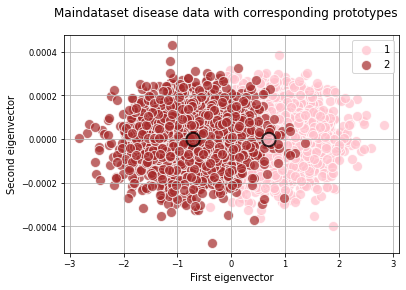

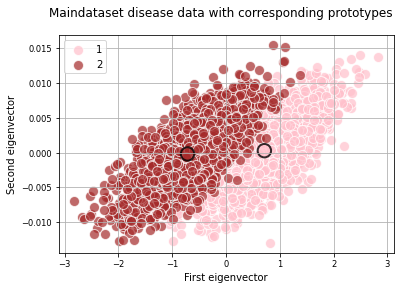

In [45]:

visualizeSinglemodel(modeld,scalarId,data,labelsdiseases,modeld.eigenvalues_,modeld.eigenvectors_,modeld.prototypes_)

averageprototype(modeld,scalar,data,labelsdiseases,eigenvaluesdisease,eigenvectorsdisease,average_prototype_disease)



##########################center####################################

#visualizeSinglemodelc(modelc,scalarIc,data,labelscenter,modelc.eigenvalues_,modelc.eigenvectors_,modelc.prototypes_)
#averageprototypec(modelc,scalarIc,data,labelscenter,eigenvaluescenter,eigenvectorscenter,average_prototype_center)

## visualize models 6 class

In [35]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalues(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values with correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal with correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [36]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalueswithout(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values without correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal without correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [37]:
## average 

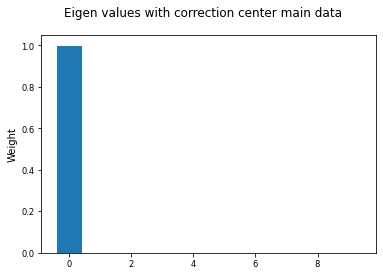

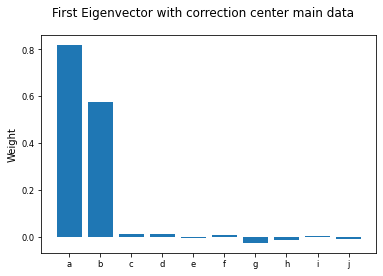

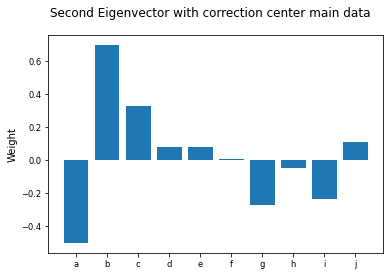

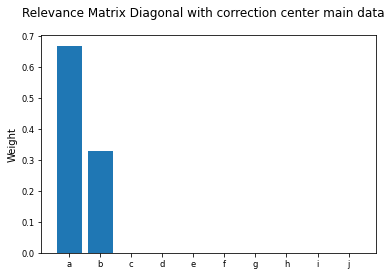

In [38]:
ploteigenvalues(eigenvaluescenter,eigenvectorscenter,average_lambda_center,'center')

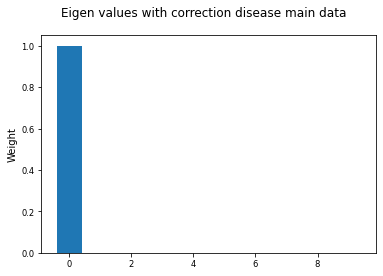

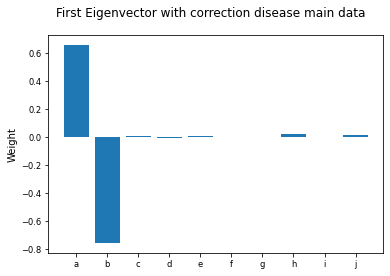

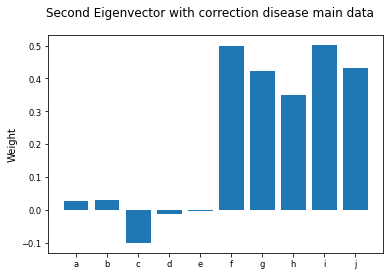

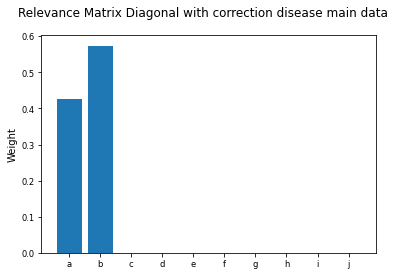

In [46]:
ploteigenvalues(modeld.eigenvalues_,modeld.eigenvectors_,modeld.lambda_,'disease')

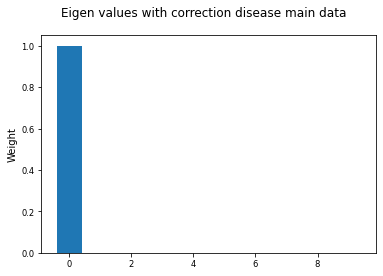

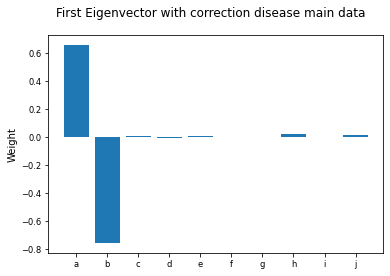

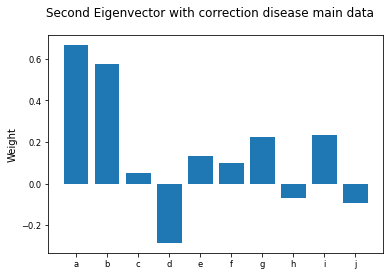

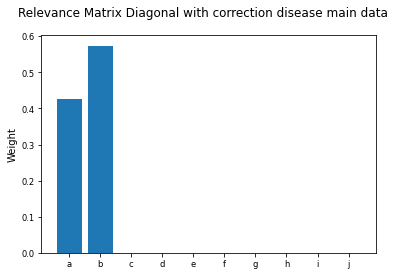

In [47]:
ploteigenvalues(eigenvaluesdisease,eigenvectorsdisease,average_lambda_disease,'disease')

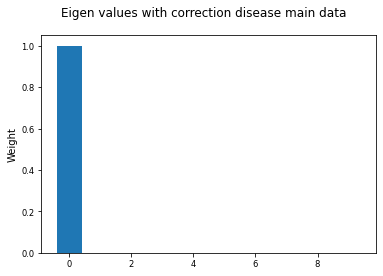

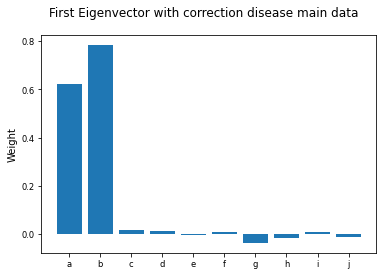

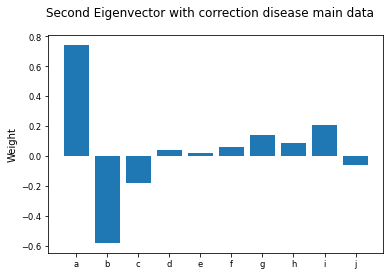

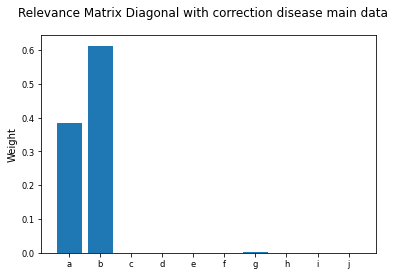

In [41]:
ploteigenvalues(modelc.eigenvalues_,modelc.eigenvectors_,modelc.lambda_,'disease')